In [1]:
%matplotlib inline
%precision 16
import numpy
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
from scipy.integrate import quad

## Test for backward euler method

Set variables related to change of variables: $(S,v)\rightarrow(\xi, \eta)$

In [2]:
K     = 1200.0

# Stock spatial space
S_max = 2000.0
S_min = 400.0
alpha = S_max - S_min

# Variance space
v_max = 0.002
v_min = 0.0
beta  = v_max - v_min

c1    = numpy.arcsinh( (S_max - K)/alpha )
c2    = numpy.arcsinh( (S_min - K)/alpha )
d1    = numpy.arcsinh( v_max/beta )

Set coefficients of heston pde

In [3]:
rho   = -0.5
sigma = 0.01
r     = 0.01
q     = 0.0
kappa = 0.02
theta = 0.04

Set grid

In [4]:
t_final = 0.02
N = 20
M = 10
L = 3

xi  = numpy.linspace(0, 1, N+2) 
eta = numpy.linspace(0, 1, M+2)
t   = numpy.linspace(0, t_final, L)

# Interior points
#xi  =  xi[1:-1] 
#eta = eta[1:-1]

delta_xi  =  xi[1] -  xi[0]
delta_eta = eta[1] - eta[0]
delta_t   =   t[1] -   t[0]

print delta_xi
print delta_eta
print delta_t

0.047619047619
0.0909090909091
0.01


Common function that needs during entire run time

In [5]:
S         = lambda xi: K + alpha * numpy.sinh( c1*xi + c2*(1-xi) )
dSdxi     = lambda xi: alpha * numpy.cosh( c1*xi + c2*(1-xi) ) * (c1 - c2)
d2Sdxi2   = lambda xi: alpha * numpy.sinh( c1*xi + c2*(1-xi) ) * (c1 - c2)**2

v         = lambda eta: beta*numpy.sinh( d1*eta )
dvdeta    = lambda eta: numpy.cosh( d1*eta ) * d1 * beta
d2vdeta2  = lambda eta: numpy.sinh( d1*eta ) * d1**2 * beta

Allocate solution vector U

In [6]:
U = numpy.empty([N+2, M+2])
U_interior_old = numpy.zeros(N*M)
U_interior_new = numpy.zeros(N*M)

In [ ]:
def Heston_Integral(phi, K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, j):
    
    u_1 = 1.0 / 2.0
    u_2 = - 1.0 / 2.0
    a = kappa * theta
    rspi = rho * sigma * phi * 1j
    tau = T - t
    
    b_1 = kappa + _lambda - rho * sigma
    b_2 = kappa + _lambda
    
    d_1 = numpy.sqrt((rspi - b_1)**2 - sigma**2 * (2.0 * u_1 * phi * 1j - phi**2))
    d_2 = numpy.sqrt((rho * sigma * phi * 1j - b_2)**2 - sigma**2 * (2.0 * u_2 * phi * 1j - phi**2))
    
    g_1 = (b_1 - rspi + d_1) / (b_1 - rspi - d_1)
    g_2 = (b_2 - rspi + d_2) / (b_2 - rspi - d_2)
   
    D_1 = (b_1 - rspi + d_1) / sigma**2 * ((1.0 - numpy.exp(d_1 * tau)) / (1.0 - g_1 * numpy.exp(d_1 * r)))
    D_2 = (b_2 - rspi + d_2) / sigma**2 * ((1.0 - numpy.exp(d_2 * tau)) / (1.0 - g_2 * numpy.exp(d_2 * r)))
    
    C_1 = r * phi * 1j * tau + a / sigma**2 * ((b_1 - rspi + d_1) * tau - 2.0 * numpy.log((1.0 - g_1 * numpy.exp(d_1 * tau))/(1.0 - g_1)))
    C_2 = r * phi * 1j * tau + a / sigma**2 * ((b_2 - rspi + d_2) * tau - 2.0 * numpy.log((1.0 - g_2 * numpy.exp(d_2 * tau))/(1.0 - g_2)))   
    
    f_1 = numpy.exp(C_1 + D_1 * v + 1j * phi * numpy.log(S))
    f_2 = numpy.exp(C_2 + D_2 * v + 1j * phi * numpy.log(S))
    
    if(j==1):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_1)/(1j * phi))
    elif(j==2):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_2)/(1j * phi))

In [ ]:
def Exact_Solution(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda):
    
    P_1 = 0.5 + 1.0 / numpy.pi * quad(Heston_Integral, 0, 1000, args=(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, 1))[0]
    P_2 = 0.5 + 1.0 / numpy.pi * quad(Heston_Integral, 0, 1000, args=(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, 2))[0]
    
    Call = S * P_1 - K * numpy.exp(- r * (T - t)) * P_2
    return Call

Set function to construct matrix A

In [7]:
a = lambda i,j: delta_t*rho*sigma/(4.0*delta_xi*delta_eta)*v(eta[j])*S(xi[i])/(dSdxi(xi[i]) * dvdeta(eta[j]))
b = lambda i,j: sigma**2 * delta_t/(2.0*delta_eta**2)*v(eta[j])/dvdeta(eta[j])**2 - \
                delta_t/(2.0*delta_eta)*(kappa*(theta-v(eta[j]))/dvdeta(eta[j]) - \
                0.5*sigma**2*v(eta[j])*d2vdeta2(eta[j])/dvdeta(eta[j])**3)
c = lambda i,j: delta_t/delta_xi**2*v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 - \
                delta_t/(2.0*delta_xi)*((r-q)*S(xi[i])/dSdxi(xi[i]) - 0.5*v(eta[j])*S(xi[i])**2*d2Sdxi2(xi[i])/dSdxi(xi[i])**3)
d = lambda i,j: 1 + r*delta_t + delta_t/delta_xi**2 * v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 + \
                sigma**2*delta_t/delta_eta**2*v(eta[j])/dvdeta(eta[j])**2
e = lambda i,j: delta_t/delta_xi**2*v(eta[j])*S(xi[i])**2/dSdxi(xi[i])**2 + \
                delta_t/(2*delta_xi)*((r-q)*S(xi[i])/dSdxi(xi[i]) - 0.5*v(eta[j])*S(xi[i])**2*d2Sdxi2(xi[i])/dSdxi(xi[i])**3)
f = lambda i,j: sigma**2*delta_t/(2*delta_eta**2)*v(eta[j])/dvdeta(eta[j])**2 + \
                delta_t/(2.0*delta_eta)*(kappa*(theta - v(eta[j]))/dvdeta(eta[j]) - 0.5*sigma**2*v(eta[j])*d2vdeta2(eta[j])/dvdeta(eta[j])**3)

Allocate memory

In [8]:
A = numpy.zeros([M*N, M*N])
rhs = numpy.zeros(N*M)

Variables for boundary condition

In [9]:
# For bottom bc xi = 0 
_l = 2.0 * dSdxi(xi[0]) / ( dSdxi(xi[0]) + 0.5 * delta_xi * d2Sdxi2(xi[0]) )
l_ = - ( dSdxi(xi[0]) - 0.5* delta_xi * d2Sdxi2(xi[0]) ) / ( dSdxi(xi[0]) + 0.5* delta_xi* d2Sdxi2(xi[0]) )

# For upper bc xi = 1
_r = - ( dSdxi(xi[-1]) + 0.5 * delta_xi * d2Sdxi2(xi[-1]) ) / ( dSdxi(xi[-1]) - 0.5 * delta_xi * d2Sdxi2(xi[-1]) )
r_ = 2.0 * dSdxi(xi[-1]) / ( dSdxi(xi[-1]) - 0.5 * delta_xi * d2Sdxi2(xi[-1]) )

Construct matrix A

In [10]:
for irow in range(M*N):
    # U_hat[irow] == U_interior[i,j]
    i = irow/M
    j = numpy.mod(irow, M)
    
    if( i == 0 ):
        if (j == 0):
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            A[irow, irow + M]     = -e(i,j)
            A[irow, irow + M + 1] = -a(i,j)
        elif (j == M-1):
            A[irow, irow - 1]     = -b(i,j) - a(i,j)*_l
            A[irow, irow]         =  d(i,j) - c(i,j)*_l
            A[irow, irow + M - 1] =  a(i,j) - a(i,j)*l_
            A[irow, irow + M]     = -e(i,j) - c(i,j)*l_
            rhs[irow] = -a(i,j)*S(0) + f(i,j)*S(xi[i]) + a(i,j)*S(xi[i+1])
        else: # Add term for bc condition
            A[irow, irow - 1]     = -b(i,j) - a(i,j)*_l
            A[irow, irow]         =  d(i,j) - c(i,j)*_l
            A[irow, irow + 1]     = -f(i,j) + a(i,j)*_l
            A[irow, irow + M - 1] =  a(i,j) - a(i,j)*l_
            A[irow, irow + M]     = -e(i,j) - c(i,j)*l_
            A[irow, irow + M + 1] = -a(i,j) + a(i,j)*l_
    elif (i == N-1):
        if (j == 0):
            A[irow, irow - M ]    = -c(i,j) - e(i,j)*_r
            A[irow, irow - M + 1] =  a(i,j) - a(i,j)*_r
            A[irow, irow]         =  d(i,j) - e(i,j)*r_
            A[irow, irow + 1]     = -f(i,j) - a(i,j)*r_
        elif (j == M-1):
            A[irow, irow - M - 1] = -a(i,j) + a(i,j)*_r
            A[irow, irow - M ]    = -c(i,j) - e(i,j)*_r
            A[irow, irow - 1]     = -b(i,j) + a(i,j)*r_
            A[irow, irow]         =  d(i,j) - e(i,j)*r_
            rhs[irow] = -a(i,j)*S(xi[i-1]) + f(i,j)*S(xi[i]) + a(i,j)*S(1)
        else:
            A[irow, irow - M - 1] = -a(i,j) + a(i,j)*_r
            A[irow, irow - M ]    = -c(i,j) - e(i,j)*_r
            A[irow, irow - M + 1] =  a(i,j) - a(i,j)*_r
            A[irow, irow - 1]     = -b(i,j) + a(i,j)*r_
            A[irow, irow]         =  d(i,j) - e(i,j)*r_
            A[irow, irow + 1]     = -f(i,j) - a(i,j)*r_
    else:
        if (j == 0):   
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - M + 1] = -a(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            A[irow, irow + M]     = -e(i,j)
            A[irow, irow + M + 1] =  a(i,j)
        elif (j == M-1):
            A[irow, irow - M - 1] = -a(i,j) 
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - 1]     = -b(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + M - 1] =  a(i,j)
            A[irow, irow + M]     = -e(i,j)
            rhs[irow] = -a(i,j)*S(xi[i-1]) + f(i,j)*S(xi[i]) + a(i,j)*S(xi[i+1])
        else:
            A[irow, irow - M - 1] = -a(i,j) 
            A[irow, irow - M ]    = -c(i,j)
            A[irow, irow - M + 1] =  a(i,j)
            A[irow, irow - 1]     = -b(i,j)
            A[irow, irow]         =  d(i,j)
            A[irow, irow + 1]     = -f(i,j)
            A[irow, irow + M - 1] =  a(i,j)
            A[irow, irow + M]     = -e(i,j)
            A[irow, irow + M + 1] = -a(i,j)
# sA = sparse.csr_matrix(A)

1.04891595804
-0.0376309627527
322.728849638


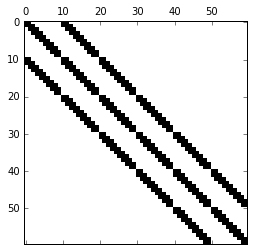

In [11]:
fig = plt.figure()
plt.spy(A[0:60, 0:60])
print numpy.max(A)
print numpy.min(A)

E, X = numpy.meshgrid(numpy.linspace(0,1,N*M), numpy.linspace(0,1,N*M))
# Plot solution
# fig = plt.figure()
# axes = fig.add_subplot(1, 1, 1)
# sol_plot = axes.pcolor(E, X, A)
# axes.set_title("Element of A")
# axes.set_xlabel("eta")
# axes.set_ylabel("xi")
# cbar = fig.colorbar(sol_plot, ax=axes)
# plt.show
print numpy.linalg.det(A)

Construct A_bc

1.00020646892


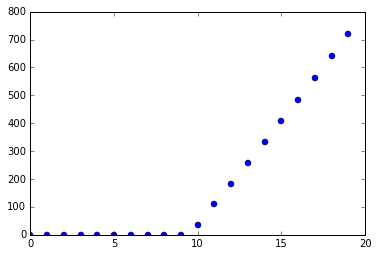

In [12]:
# For each time step, we need to first solve the pde for lower boundary condition
# lower bc
# Construct matrix A_bc for boundary condition
alpha_bc = (r-q) * delta_t/(2.0 * delta_xi) * S(xi)/dSdxi(xi)
beta_bc = kappa*theta*delta_t / ( 2*delta_eta*dvdeta(0) )

maindiag = numpy.ones(N)*(1 + r*delta_t)
maindiag[0] += alpha_bc[0] * _l
maindiag[-1] -= alpha_bc[-1] * r_

upperdiag = numpy.zeros(N)
upperdiag[1:] = -alpha_bc[:-1]
upperdiag[1] += alpha_bc[0] * l_

lowerdiag = numpy.zeros(N)
lowerdiag[:-1] = alpha_bc[1:]
lowerdiag[-2] -= alpha_bc[-1]*_r

A_bc = sparse.spdiags([lowerdiag, maindiag, upperdiag], [-1, 0, 1], N, N).tocsr()
print numpy.linalg.det(A_bc.todense())

#initialize U_bc vector
U_bc = numpy.zeros(N)
U_bc = numpy.maximum(0, S(xi) - K)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(range(N), U_bc, 'o')

Do backward Euler, $AU^{n+1} = U^{n} + rhs$

Initialize U vector

In [13]:
for i in range(N):
    U_interior_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * S(xi[i]) - K , 0.0)
# Add for test
U_init = numpy.copy(U_interior_old)

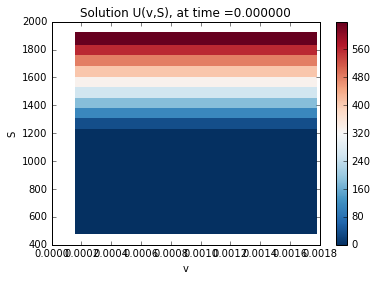

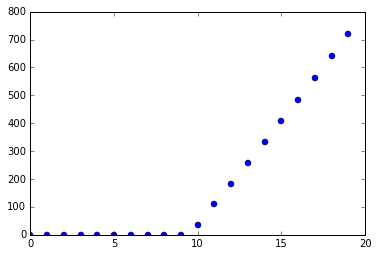

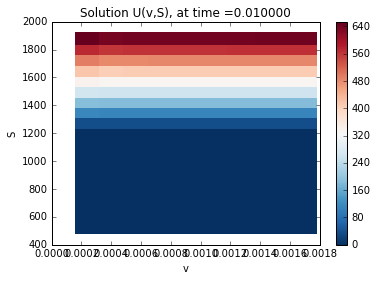

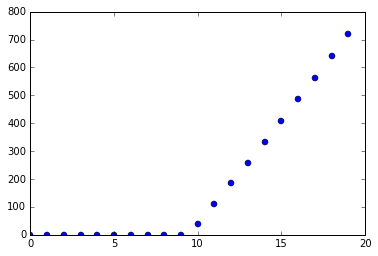

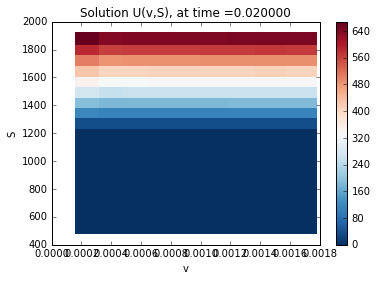

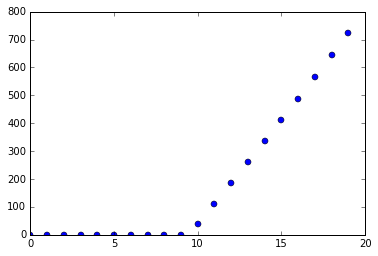

In [14]:
for timestep in t:
    E, X = numpy.meshgrid(v(eta), S(xi))
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    sol_plot = axes.pcolor(E, X, numpy.reshape(U_interior_old, [N, M]), cmap=plt.get_cmap('RdBu_r'))
    axes.set_title("Solution U(v,S), at time =%f"%(timestep))
    axes.set_xlabel("v")
    axes.set_ylabel("S")
    cbar = fig.colorbar(sol_plot, ax=axes)

    #rhs (Need U vector in previous time step)
    rhs_bc = numpy.zeros(N)
    for i in range(len(rhs_bc)):
        rhs_bc[i] = (-3.0*beta_bc+1)*U_bc[i] + 4.0*beta_bc*U_interior_old[i*M] - beta_bc*U_interior_old[i*M+1]
    U_bc = linalg.spsolve(A_bc, rhs_bc)
    
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(range(N), U_bc, 'o')
    
    # After solve the lower boundary condition, update the corresponding rhs
    for i in range(N):
        if i==0:
            rhs[i*M] = a(i,0)*( U_bc[i+1]*l_ + U_bc[i]*_l ) + b(i,0)*U_bc[i] - a(i,0)*U_bc[i+1]
        elif i==N-1:
            rhs[i*M] = a(i,0)*U_bc[i-1] + b(i,0)*U_bc[i] - a(i,0)*( U_bc[i-1]*_r + U_bc[i]*r_ )
        else:
            rhs[i*M] = a(i,0)*U_bc[i-1] + b(i,0)*U_bc[i] - a(i,0)*U_bc[i+1]
    U_interior_new = numpy.linalg.solve(A, U_interior_old)
#    U_interior_new = numpy.linalg.solve(A, U_interior_old + rhs)
#     U_interior_new = linalg.spsolve(sA, U_interior_old + rhs)
    U_interior_old = numpy.copy(U_interior_new)
    

In [15]:
# for i in xrange(1,N):
#     if i==N-1:
#         print A_bc[i,i-1], alpha_bc[i]
#     else:
#         print A_bc[i,i-1], A_bc[i,i+1], alpha_bc[i]
# print alpha_bc[0] * l_

Reshape the U vector

In [16]:
U_interior = numpy.reshape(U_interior_new, [N, M])
print U_interior.shape

(20, 10)


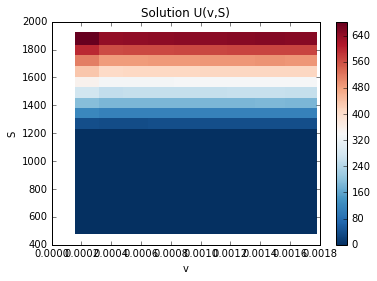

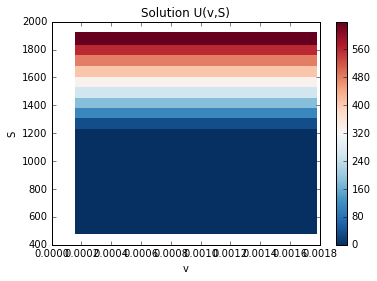

0.00177955350148 1918.82893423
637.341333975


In [17]:
E, X = numpy.meshgrid(v(eta), S(xi))
#E, X = numpy.meshgrid(eta, xi)
# fig = plt.figure()
# # Plot right boundary condition
# axes = fig.add_subplot(1, 1, 1)
# axes.plot(xi, S(xi), 'o')

# fig = plt.figure()
# axes = fig.add_subplot(1, 1, 1)
# axes.plot(eta, v(eta), 'o')
# Plot solution
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, U_interior, cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)
# Plot initial data
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, numpy.reshape(U_init, [N, M]), cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)
plt.show()

print v(eta[-1]), S(xi[-1])
print U_interior[-1,-1]